In [ ]:
import os

zip_file_path = '/content/drive/MyDrive/character_recognisation/archive1.zip'
extract_to_path = '/content/drive/MyDrive/character_recognisation/'

# Unzip using the system's unzip command
os.system(f'unzip -q {zip_file_path} -d {extract_to_path}')

print("Unzipping completed!")


Unzipping completed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/character_recognisation

/content/drive/MyDrive/character_recognisation


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [ ]:
data_dir = '/content/drive/MyDrive/character_recognisation/character_ocr'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)), # Resize images to 32x32 pixels
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])  # To normalize image

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")
print(f"Total number of images: {len(dataset)}")

Classes: ['क', 'को', 'ख', 'ग', 'च', 'ज', 'झ', 'ञ', 'डि', 'त', 'ना', 'प', 'प्र', 'ब', 'बा', 'भे', 'म', 'मे', 'य', 'लु', 'सी', 'सु', 'से', 'ह', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
Number of classes: 34
Total number of images: 26537


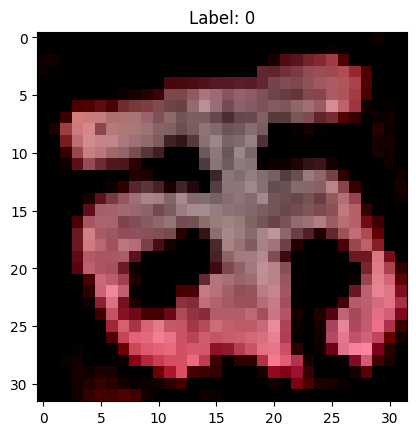

class name क


In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming image is a PyTorch tensor
image, label = dataset[0]
# Convert the image from (channels, height, width) to (height, width, channels)
image = image.permute(1, 2, 0)
# If the image is a tensor, convert it to a numpy array for plotting
if isinstance(image, torch.Tensor):
    image = image.numpy()
# Plot the image
plt.imshow(image)
plt.title(f'Label: {label}')
plt.show()
print("class name",class_names[label])

In [ ]:
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class Conv2D(nn.Module):
  def __init__(self, in_channels,out_channels,kernel_size,stride=1,padding='same') -> None:
     super(Conv2D,self).__init__()
     self.in_channels=in_channels
     self.out_channels=out_channels
     self.kernel_size=(kernel_size,kernel_size) if isinstance (kernel_size,int) else kernel_size
     self.stride=stride
     self.padding=padding
     self.weight=nn.Parameter(torch.nn.init.xavier_uniform_(torch.empty(self.out_channels,self.in_channels,*self.kernel_size,requires_grad=True)))
     self.bias=nn.Parameter(torch.zeros(self.out_channels,requires_grad=True))
  def forward(self,x):
     x=F.conv2d(x,self.weight,self.bias,self.stride,self.padding)
     x=F.relu(x)
     return x

In [ ]:
class MaxPool(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MaxPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding
    def forward(self, x):
        x=F.max_pool2d(x,self.kernel_size,self.stride,self.padding)
        return x

In [ ]:
class Dense(nn.Module):
    def __init__(self, in_features, out_features):

        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )

    def forward(self, x):
        x=torch.mm(x,self.weight)+self.bias
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # parameters for conv layers
        filter_dim = 3
        in_channels = [3, 16, 32, 32]
        out_channels = [16, 32, 32, 64]
        # parameters for dense layers
        dense_in_features = [4096, 256]
        dense_out_features = [256, 34]

        # initializing all the layers
        self.c1 = Conv2D(in_channels[0], out_channels[0], filter_dim)
        self.c2 = Conv2D(in_channels[1], out_channels[1], filter_dim)
        self.m1 = MaxPool(2)
        self.dropout = nn.Dropout(p=0.25)
        self.c3 = Conv2D(in_channels[2], out_channels[2], filter_dim)
        self.c4=Conv2D(in_channels[3],out_channels[3],filter_dim)
        self.m2=MaxPool(2)
        self.d1=Dense(dense_in_features[0],dense_out_features[0])
        self.d2 = Dense(dense_in_features[1], dense_out_features[1])

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.m1(x)
        x = self.dropout(x)
        x = self.c3(x)

        x=self.c4(x)
        x=self.m2(x)
        x=self.dropout(x)
        x = x.view(x.size(0), -1)
        x=self.d1(x)
        x=F.relu(x)
        x = self.d2(x)
        return x

In [ ]:
model = CNNModel()

In [ ]:
def loss(target_y, predicted_y):
    cost=F.cross_entropy(predicted_y,target_y)
    return cost

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device

device(type='cuda', index=0)

In [ ]:
def train(model: nn.Module, inputs, outputs, optimizer: torch.optim.Optimizer):
    optimizer.zero_grad()
    y_predicted = model(inputs)
    y = outputs
    current_loss = loss(y, y_predicted)
    current_loss.backward()
    optimizer.step()
    return current_loss, y_predicted

In [ ]:
%cd /content/drive/MyDrive/character_recognisation

/content/drive/MyDrive/character_recognisation


In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='ocr.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, self.path)
        self.val_loss_min = val_loss

In [ ]:

from tqdm import tqdm

def train_and_evaluate(model, train_loader, test_loader, optimizer, loss, num_epochs, device, early_stopping):
    train_acc_per_epoch = []
    val_acc_per_epoch = []

    train_loss_per_epoch = []
    val_loss_per_epoch = []

    print("Training")
    for epoch in range(num_epochs):
        train_loss = []
        train_acc = []
        model.train()
        for num, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            losses, pred = train(model, x_batch, y_batch, optimizer)
            train_loss.append(losses.item())
            train_acc.append((y_batch == pred.argmax(dim=-1)).float().mean().item())

        val_loss = []
        val_acc = []
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                val_pred = model(x_batch)
                val_loss.append(loss(y_batch, val_pred).item())
                val_acc.append((y_batch == val_pred.argmax(dim=-1)).float().mean().item())

        print('\nEpoch: {}\tTrain Loss: {}\tTrain Accuracy: {}\n\t\tVal Loss: \
        {}\tVal Accuracy: {}\n'.format(
             epoch+1, np.mean(train_loss), np.mean(train_acc), np.mean(val_loss),
             np.mean(val_acc)
        ))

        # Tracking accuracy in each epoch for plot
        train_acc_per_epoch.append(np.mean(train_acc))
        val_acc_per_epoch.append(np.mean(val_acc))
        # tracking loss in each epoch for plot
        train_loss_per_epoch.append(np.mean(train_loss))
        val_loss_per_epoch.append(np.mean(val_loss))
        # Early stopping
        early_stopping(np.mean(val_loss), model)
        if early_stopping.early_stop:
                print("Early stopping")
                break
    checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc_per_epoch': train_acc_per_epoch,
    'val_acc_per_epoch': val_acc_per_epoch,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch,
    }
    torch.save(checkpoint, 'checkpoint.pth.tar')
    return train_acc_per_epoch, val_acc_per_epoch,train_loss_per_epoch, val_loss_per_epoch


In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=True)
num_epochs = 500
train_acc_per_epoch, val_acc_per_epoch,train_loss_per_epoch, val_loss_per_epoch = train_and_evaluate(model, train_loader, val_loader, optimizer, loss, num_epochs, device, early_stopping)

Training


100%|██████████| 291/291 [01:11<00:00,  4.08it/s]



Epoch: 1	Train Loss: 0.895207715294359	Train Accuracy: 0.766698883161512
		Val Loss:         0.17735122705259956	Val Accuracy: 0.9583801304001406

Validation loss decreased (inf --> 0.177351).  Saving model ...


100%|██████████| 291/291 [01:05<00:00,  4.45it/s]



Epoch: 2	Train Loss: 0.14661104427298524	Train Accuracy: 0.9595682989690721
		Val Loss:         0.09360436956027904	Val Accuracy: 0.9738168773880924

Validation loss decreased (0.177351 --> 0.093604).  Saving model ...


100%|██████████| 291/291 [01:04<00:00,  4.50it/s]



Epoch: 3	Train Loss: 0.087529870987905	Train Accuracy: 0.9749785223367697
		Val Loss:         0.08178722014347742	Val Accuracy: 0.9798569277108434

Validation loss decreased (0.093604 --> 0.081787).  Saving model ...


100%|██████████| 291/291 [01:04<00:00,  4.52it/s]



Epoch: 4	Train Loss: 0.07202898305792783	Train Accuracy: 0.9790986542849197
		Val Loss:         0.08942048038434551	Val Accuracy: 0.9770012253738312

EarlyStopping counter: 1 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.60it/s]



Epoch: 5	Train Loss: 0.053020535063525005	Train Accuracy: 0.9860395189003437
		Val Loss:         0.07364009648522205	Val Accuracy: 0.9811587448579719

Validation loss decreased (0.081787 --> 0.073640).  Saving model ...


100%|██████████| 291/291 [01:04<00:00,  4.54it/s]



Epoch: 6	Train Loss: 0.046134418852829706	Train Accuracy: 0.9873138604704866
		Val Loss:         0.07258240149934293	Val Accuracy: 0.9824765159423092

Validation loss decreased (0.073640 --> 0.072582).  Saving model ...


100%|██████████| 291/291 [01:03<00:00,  4.55it/s]



Epoch: 7	Train Loss: 0.04380446250123993	Train Accuracy: 0.9878114261168385
		Val Loss:         0.11787623852485768	Val Accuracy: 0.9674003217593733

EarlyStopping counter: 1 out of 10


100%|██████████| 291/291 [01:04<00:00,  4.53it/s]



Epoch: 8	Train Loss: 0.03429746598168716	Train Accuracy: 0.9902813573883161
		Val Loss:         0.06681635635989124	Val Accuracy: 0.9849238050989357

Validation loss decreased (0.072582 --> 0.066816).  Saving model ...


100%|██████████| 291/291 [01:04<00:00,  4.55it/s]



Epoch: 9	Train Loss: 0.03234052438212117	Train Accuracy: 0.9911404639175257
		Val Loss:         0.08514228834720126	Val Accuracy: 0.9803897795906986

EarlyStopping counter: 1 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.57it/s]



Epoch: 10	Train Loss: 0.03363910271844961	Train Accuracy: 0.9901202749140894
		Val Loss:         0.08063872211229853	Val Accuracy: 0.9838102409638554

EarlyStopping counter: 2 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.61it/s]



Epoch: 11	Train Loss: 0.024869583040398636	Train Accuracy: 0.9932882302405498
		Val Loss:         0.07049773515942674	Val Accuracy: 0.9853003111230322

EarlyStopping counter: 3 out of 10


100%|██████████| 291/291 [01:04<00:00,  4.51it/s]



Epoch: 12	Train Loss: 0.027043512199854933	Train Accuracy: 0.992053264604811
		Val Loss:         0.062263614549098185	Val Accuracy: 0.9873710942555622

Validation loss decreased (0.066816 --> 0.062264).  Saving model ...


100%|██████████| 291/291 [01:03<00:00,  4.57it/s]



Epoch: 13	Train Loss: 0.022717112928667526	Train Accuracy: 0.9933419243986255
		Val Loss:         0.0543205663070913	Val Accuracy: 0.9892536243760442

Validation loss decreased (0.062264 --> 0.054321).  Saving model ...


100%|██████████| 291/291 [01:03<00:00,  4.58it/s]



Epoch: 14	Train Loss: 0.026497096312852398	Train Accuracy: 0.9922143470790378
		Val Loss:         0.08133054401091558	Val Accuracy: 0.9815352508820683

EarlyStopping counter: 1 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.60it/s]



Epoch: 15	Train Loss: 0.024845103772190433	Train Accuracy: 0.9929123711340206
		Val Loss:         0.05650154507279092	Val Accuracy: 0.9898024301931082

EarlyStopping counter: 2 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.56it/s]



Epoch: 16	Train Loss: 0.016919445503678625	Train Accuracy: 0.9948990549828178
		Val Loss:         0.07755685099079737	Val Accuracy: 0.9849238050989357

EarlyStopping counter: 3 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.57it/s]



Epoch: 17	Train Loss: 0.02610821775608789	Train Accuracy: 0.992053264604811
		Val Loss:         0.05660510216720391	Val Accuracy: 0.9881400602409639

EarlyStopping counter: 4 out of 10


100%|██████████| 291/291 [01:04<00:00,  4.54it/s]



Epoch: 18	Train Loss: 0.018145233094038645	Train Accuracy: 0.9952749140893471
		Val Loss:         0.08618524857058263	Val Accuracy: 0.9849238050989357

EarlyStopping counter: 5 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.56it/s]



Epoch: 19	Train Loss: 0.01455682744878133	Train Accuracy: 0.9952069017076001
		Val Loss:         0.08787518740743497	Val Accuracy: 0.9868063352194177

EarlyStopping counter: 6 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.55it/s]



Epoch: 20	Train Loss: 0.02179183899458162	Train Accuracy: 0.9938645477557101
		Val Loss:         0.09367201112597165	Val Accuracy: 0.9806099397590361

EarlyStopping counter: 7 out of 10


100%|██████████| 291/291 [01:05<00:00,  4.42it/s]



Epoch: 21	Train Loss: 0.027676794770128674	Train Accuracy: 0.9913552405498282
		Val Loss:         0.07981994715505224	Val Accuracy: 0.9837942870266466

EarlyStopping counter: 8 out of 10


100%|██████████| 291/291 [01:03<00:00,  4.59it/s]



Epoch: 22	Train Loss: 0.014283501967773041	Train Accuracy: 0.9957581615120275
		Val Loss:         0.07011065732321328	Val Accuracy: 0.9890813253012049

EarlyStopping counter: 9 out of 10


100%|██████████| 291/291 [01:04<00:00,  4.52it/s]



Epoch: 23	Train Loss: 0.01607834645519094	Train Accuracy: 0.9953286082474226
		Val Loss:         0.05861405446281774	Val Accuracy: 0.9877635542168675

EarlyStopping counter: 10 out of 10
Early stopping


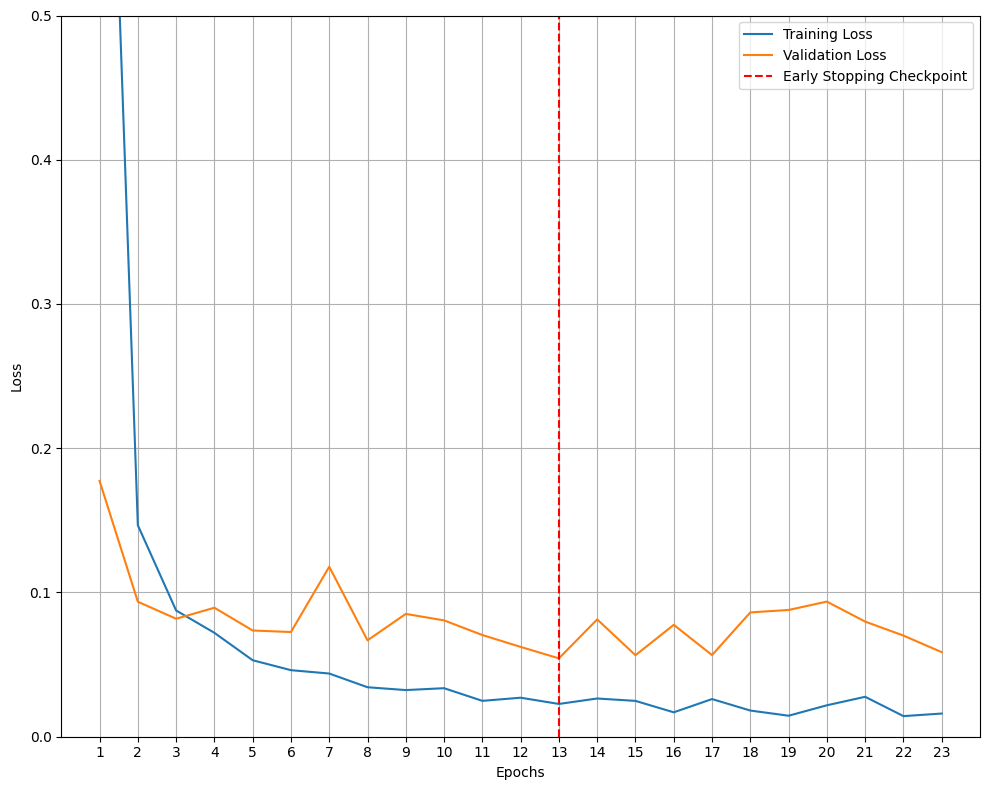

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_loss_per_epoch, val_loss_per_epoch):
    fig = plt.figure(figsize=(10, 8))

    # Plot training and validation loss
    plt.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch, label='Training Loss')
    plt.plot(range(1, len(val_loss_per_epoch) + 1), val_loss_per_epoch, label='Validation Loss')

    # Find position of the lowest validation loss
    min_pos = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    plt.axvline(min_pos, linestyle='--', color='r', label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.5)  # Adjust this if needed based on your loss range
    plt.xlim(0, len(train_loss_per_epoch) + 1)  # Consistent scale

    # Set x-axis ticks to be integers only
    plt.xticks(range(1, len(train_loss_per_epoch) + 1))

    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save the figure
    fig.savefig('loss_plot.png', bbox_inches='tight')
    plt.show()

# Example data

plot_training_history(train_loss_per_epoch, val_loss_per_epoch)


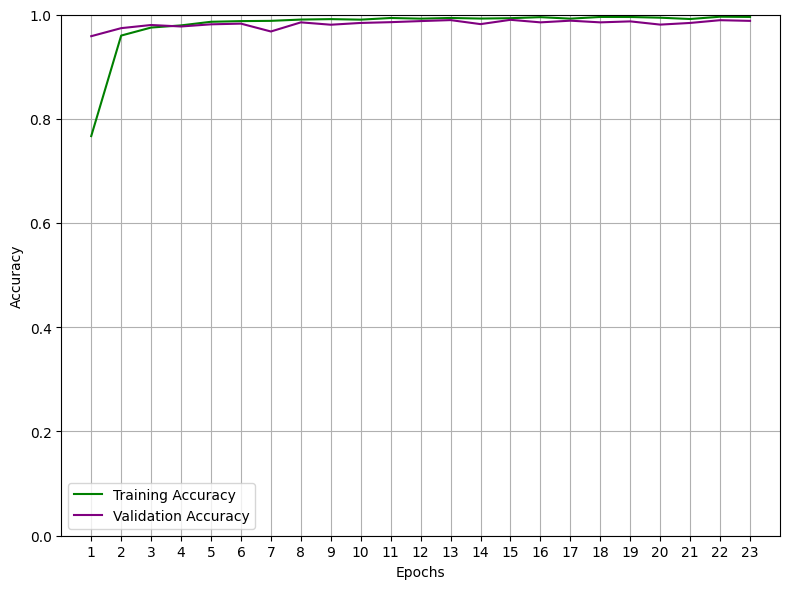

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc_per_epoch, val_acc_per_epoch):
    fig = plt.figure(figsize=(8, 6))

    # Plot training and validation accuracy
    plt.plot(range(1, len(train_acc_per_epoch) + 1), train_acc_per_epoch, label='Training Accuracy', color='g')
    plt.plot(range(1, len(val_acc_per_epoch) + 1), val_acc_per_epoch, label='Validation Accuracy', color='purple')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Adjust this if needed based on your accuracy range
    plt.xlim(0, len(train_acc_per_epoch) + 1)  # Consistent scale
    plt.xticks(range(1, len(train_acc_per_epoch) + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save the figure
    plt.savefig('accuracy_plot.png', bbox_inches='tight')
    plt.show()

# Example data for accuracy

plot_accuracy(train_acc_per_epoch, val_acc_per_epoch)


In [ ]:
import torch

# Load the checkpoint
checkpoint = torch.load('/content/drive/MyDrive/character_recognisation/checkpoint.pth.tar')

# Retrieve model and optimizer state dictionaries
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']

# Retrieve training and validation metrics
train_acc_per_epoch = checkpoint['train_acc_per_epoch']
val_acc_per_epoch = checkpoint['val_acc_per_epoch']
train_loss_per_epoch = checkpoint['train_loss_per_epoch']
val_loss_per_epoch = checkpoint['val_loss_per_epoch']

# Print or use the metrics as needed
print("Training Accuracy per Epoch:", train_acc_per_epoch)
print("Validation Accuracy per Epoch:", val_acc_per_epoch)
print("Training Loss per Epoch:", train_loss_per_epoch)
print("Validation Loss per Epoch:", val_loss_per_epoch)

# To use the state dictionaries, you need to load them into the model and optimizer
# For example:
# model.load_state_dict(model_state_dict)
# optimizer.load_state_dict(optimizer_state_dict)


Training Accuracy per Epoch: [0.766698883161512, 0.9595682989690721, 0.9749785223367697, 0.9790986542849197, 0.9860395189003437, 0.9873138604704866, 0.9878114261168385, 0.9902813573883161, 0.9911404639175257, 0.9901202749140894, 0.9932882302405498, 0.992053264604811, 0.9933419243986255, 0.9922143470790378, 0.9929123711340206, 0.9948990549828178, 0.992053264604811, 0.9952749140893471, 0.9952069017076001, 0.9938645477557101, 0.9913552405498282, 0.9957581615120275, 0.9953286082474226]
Validation Accuracy per Epoch: [0.9583801304001406, 0.9738168773880924, 0.9798569277108434, 0.9770012253738312, 0.9811587448579719, 0.9824765159423092, 0.9674003217593733, 0.9849238050989357, 0.9803897795906986, 0.9838102409638554, 0.9853003111230322, 0.9873710942555622, 0.9892536243760442, 0.9815352508820683, 0.9898024301931082, 0.9849238050989357, 0.9881400602409639, 0.9849238050989357, 0.9868063352194177, 0.9806099397590361, 0.9837942870266466, 0.9890813253012049, 0.9877635542168675]
Training Loss per Epo

<ipython-input-25-86395217b472>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/character_recognisation/checkpoint.pth.tar')

In [ ]:
mode=torch.load('/content/drive/MyDrive/character_recognisation/ocr.pt')

<ipython-input-27-8b1b8b16b4cf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mode=torch.load('/content/drive/MyDrive/character_recognisation/ocr.pt')


In [ ]:
# Example inference on a single image
from PIL import Image

# Load and preprocess the image
image_path = '/content/drive/MyDrive/character_recognisation/character_ocr/७/७_10.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)  # Apply the same transforms used for training

# Perform prediction
mode.eval()
with torch.no_grad():
    output = mode(image)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f'Predicted class: {predicted_class}')

Predicted class: ७
